In [1]:
import os
import sys
from tqdm import tqdm
from PIL import Image
import numpy as np
import shutil

sys.path.extend(['..'])

from utils.config import process_config

import tensorflow as tf
from tensorflow.layers import (conv2d, max_pooling2d, average_pooling2d, batch_normalization, dropout, dense)
from tensorflow.nn import (relu, sigmoid, softmax, leaky_relu)
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.utils import shuffle

In [2]:
DATA = '../data/data_clean/'
CONF = '../configs/roman.json'

In [3]:
def normalize(image):
    return (image - image.min()) / (image.max() - image.min())

def shuffle_sim(a, b):
    assert a.shape[0] == a.shape[0], 'Shapes must be equal'
    
    ind = np.arange(a.shape[0])
    np.random.shuffle(ind)
    return a[ind], b[ind]

In [4]:
def read_train_test(path_to_data):
    data = {}
    for dset in ['train', 'test']:
        path_ = os.path.join(path_to_data, dset)
        X, Y = [], []
        classes = [d for d in os.listdir(path_) if os.path.isdir(os.path.join(path_, d))]
        classes.sort()
        
        for cl in classes:
            y = np.zeros((1, 8), dtype=np.int32)
            y[0, int(cl) - 1] = 1
            
            cl_path = os.path.join(path_, cl)
            filenames = [os.path.join(cl_path, pict) for pict in os.listdir(cl_path) if pict.endswith('.jpg')]
            
            for im in filenames:
                image = np.asarray(Image.open(im), dtype=np.float32)
                X.append(normalize(image).reshape((1, image.shape[0], image.shape[1], image.shape[2])))
                Y.append(y)
        
        a, b = shuffle_sim(np.concatenate(X), np.concatenate(Y))
        data[dset] = ([a, b])
    return data

In [31]:
class Model():
    def __init__(self, config, session_config=None):
        # Configuring session
        self.config = config
        if session_config is not None:
            self.sess = tf.Session(config=session_config)
        else:
            self.sess = tf.Session()

        # Creating inputs to network
        with tf.name_scope('inputs'):
            self.x = tf.placeholder(
                dtype=tf.float32,
                shape=(None, config.image_size, config.image_size, 3))
            self.y = tf.placeholder(dtype=tf.int32, shape=(None, 8))
            self.training = tf.placeholder(dtype=tf.bool, shape=())

        # Creating epoch counter
        self.global_epoch = tf.Variable(
            0, name='global_epoch', trainable=False, dtype=tf.int32)
        self.step = tf.assign(self.global_epoch, self.global_epoch + 1)

        # Building model
        if self.config.write_histograms:
            self.histograms = {}
        self.__build_model()

        # Summary writer
        self.summ_writer_train = tf.summary.FileWriter(
            config.train_summary_dir, graph=self.sess.graph)
        self.summ_writer_test = tf.summary.FileWriter(config.test_summary_dir)

        self.sess.run(tf.global_variables_initializer())

        # Saver
        self.saver = tf.train.Saver(max_to_keep=1, name='saver')

    def __initialize_local(self):
        self.sess.run(tf.local_variables_initializer())
        self.histograms = {}

    def clear_summaries(self):
        # IT IS BUGGY
        for file in os.listdir(self.config.train_summary_dir):
            os.remove(os.path.join(self.config.train_summary_dir, file))

        for file in os.listdir(self.config.test_summary_dir):
            os.remove(os.path.join(self.config.test_summary_dir, file))

    def __add_histogram(self, scope, name, var):
        dict_var = scope.name + '/' + name
        hist = self.histograms.get(dict_var, None)
        if hist is not None:
            self.histograms[dict_var] = tf.concat([hist, var], 0)
        else:
            self.histograms[dict_var] = var
        tf.summary.histogram(name, self.histograms[dict_var])

    def plot_misclassified(self, data, batch=None):
        predicted = np.argmax(self.predict_proba(data[0], batch), axis=1)
        real = np.argmax(data[1], axis=1)
                
        matches = (real != predicted)
        mism_count = np.sum(matches.astype(np.int32))
        images = data[0][matches]
        misk = predicted[matches]
        
        fig = plt.figure(figsize=(16, int(mism_count * 1.5)))
        fig.suptitle('{} photos was misclassiified.'.format(mism_count), fontsize=16, fontweight='bold')
        columns = 4
        rows = int(np.ceil(mism_count / columns))
        for i in range(mism_count):
            s_fig = fig.add_subplot(rows, columns, i + 1)
            s_fig.set_title('Classified as {}'.format(misk[i] + 1))
            plt.imshow(images[i])
        plt.show()

    def __block(self,
                inp,
                ch,
                num,
                c_ker=[(3, 3), (3, 3)],
                c_str=[(1, 1), (1, 1)],
                act=relu,
                mp_ker=(2, 2),
                mp_str=(2, 2),
                mode='conc'):

        with tf.variable_scope('block_' + str(num)) as name:
            conv1 = conv2d(inp, ch, c_ker[0], strides=c_str[0])
            bn = batch_normalization(conv1)
            out = act(bn)
            if config.use_dropout_block:
                out = dropout(
                    out, config.dropout_rate_block, training=self.training)
            print(out.shape)

            conv2 = conv2d(out, ch, c_ker[1], strides=c_str[1])
            bn = batch_normalization(conv2)
            out = act(bn)
            print(out.shape)

            if config.write_histograms:
                self.__add_histogram(name, 'conv1', conv1)
                self.__add_histogram(name, 'conv2', conv2)

            if mode == 'mp':
                out = max_pooling2d(out, mp_ker, strides=mp_str)
            elif mode == 'ap':
                out = average_pooling2d(out, mp_ker, mp_str)
            elif mode == 'conc':
                mp = max_pooling2d(out, mp_ker, strides=mp_str)
                ap = average_pooling2d(out, mp_ker, mp_str)
                out = tf.concat([mp, ap], -1)
            else:
                raise ValueError('Unknown mode.')

            print(out.shape)
        return out

    def __build_model(self):
        with tf.name_scope('layers'):
            out = self.__block(self.x, 16, 1, mode='conc')
            out = self.__block(out, 32, 2, mode='conc')
            out = self.__block(out, 64, 3, mode='conc')
            out = self.__block(out, 256, 4, c_str=[(1, 1), (2, 2)], mode='mp')

            dim = np.prod(out.shape[1:])
            out = tf.reshape(out, [-1, dim])
            print(out.shape)

            with tf.variable_scope('dense') as scope:
                dense_l = dense(out, 128)
                out = batch_normalization(dense_l)
                out = leaky_relu(out, alpha=0.01)
                if config.use_dropout_dense:
                    out = dropout(
                        out,
                        rate=config.dropout_rate_dense,
                        training=self.training)
                print(out.shape)

                self.predictions = dense(out, 8, activation=softmax)

                if self.config.write_histograms:
                    self.__add_histogram(scope, 'dense', dense_l)
                    self.__add_histogram(scope, 'pred', self.predictions)

        with tf.name_scope('metrics'):
            amax_labels = tf.argmax(self.y, 1)
            amax_pred = tf.argmax(self.predictions, 1)

            cur_loss = tf.losses.softmax_cross_entropy(self.y,
                                                       self.predictions)
            self.loss, self.loss_update = tf.metrics.mean(cur_loss)

            cur_acc = tf.reduce_mean(
                tf.cast(tf.equal(amax_labels, amax_pred), dtype=tf.float32))
            self.acc, self.acc_update = tf.metrics.mean(cur_acc)

            self.optimize = tf.train.AdamOptimizer(
                self.config.learning_rate).minimize(cur_loss)

            tf.summary.scalar('loss', self.loss)
            tf.summary.scalar('accuracy', self.acc)

        self.summary = tf.summary.merge_all()

    def train(self, dat, epochs, dat_v=None, batch=None):
        if batch is not None:
            steps = int(np.ceil(dat[0].shape[0] / batch))
        else:
            batch = dat[0].shape[0]
            steps = 1

        for epoch in range(epochs):
            self.__initialize_local()
            summary = tf.summary.Summary()

            for step in range(steps):
                start = step * batch
                finish = (
                    step + 1) * batch if step + 1 != steps else dat[0].shape[0]

                _, _, _ = self.sess.run(
                    [self.loss_update, self.acc_update, self.optimize],
                    feed_dict={
                        self.x: dat[0][start:finish],
                        self.y: dat[1][start:finish],
                        self.training: True
                    })

            summary, loss, acc, ep = self.sess.run(
                [self.summary, self.loss, self.acc, self.step])
            self.summ_writer_train.add_summary(summary, ep)
            print(
                'EP: {:3d}\tLOSS: {:.10f}\tACC: {:.10f}\t'.format(
                    ep, loss, acc),
                end='')

            if dat_v is not None:
                self.test(dat_v, batch=batch)
            else:
                print()

    def test(self, dat, batch=None):
        if batch is not None:
            steps = int(np.ceil(dat[0].shape[0] / batch))
        else:
            steps = 1
            batch = dat[0].shape[0]

        self.__initialize_local()
        for step in range(steps):
            start = step * batch
            finish = (
                step + 1) * batch if step + 1 != steps else dat[0].shape[0]

            _, _ = self.sess.run(
                [self.loss_update, self.acc_update],
                feed_dict={
                    self.x: dat[0][start:finish],
                    self.y: dat[1][start:finish],
                    self.training: False
                })

        summary, loss, acc, ep = self.sess.run(
            [self.summary, self.loss, self.acc, self.global_epoch])
        self.summ_writer_test.add_summary(summary, ep)
        print('VALID\tLOSS: {:.10f}\tACC: {:.10f}'.format(loss, acc))

    def predict_proba(self, data, batch=None):
        if batch is not None:
            steps = int(np.ceil(data.shape[0] / batch))
        else:
            steps = 1
            batch = data.shape[0]

        self.__initialize_local()

        preds_arr = []
        for step in range(steps):
            start = step * batch
            finish = (step + 1) * batch if step + 1 != steps else data.shape[0]

            preds = self.sess.run(
                self.predictions,
                feed_dict={
                    self.x: data[start:finish],
                    self.y: np.zeros((finish - start, 8)),
                    self.training: False
                })
            preds_arr.append(preds)

        return np.concatenate(preds_arr)

    def save_model(self, model_path=None):
        gstep = self.sess.run(self.global_epoch)
        if model_path is not None:
            self.saver.save(self.sess, model_path + 'model')
        else:
            self.saver.save(self.sess, config.checkpoint_dir + 'model')

    def load_model(self, model_path=None):
        if model_path is not None:
            meta = [
                os.path.join(filename)
                for filename in os.listdir(model_path)
                if filename.endswith('.meta')
            ][0]
            self.saver = tf.train.import_meta_graph(os.path.join(model_path, meta))
            self.saver.restore(self.sess, tf.train.latest_checkpoint(model_path))
        else:
            meta = [
                os.path.join(filename)
                for filename in os.listdir(self.config.checkpoint_dir)
                if filename.endswith('.meta')
            ][0]
            self.saver = tf.train.import_meta_graph(os.path.join(self.config.checkpoint_dir, meta))
            self.saver.restore(self.sess, tf.train.latest_checkpoint(self.config.checkpoint_dir))

    def close(self):
        self.sess.close()
        tf.reset_default_graph()

In [32]:
m.close()

In [33]:
config_tf = tf.ConfigProto(allow_soft_placement=True)
config_tf.gpu_options.allow_growth = True
config_tf.gpu_options.per_process_gpu_memory_fraction = 0.95

In [34]:
config = process_config(CONF)

In [35]:
config

{'exp_name': '4bl_batch',
 'clear_summaries': False,
 'seed': 230,
 'image_size': 128,
 'train_percentage': 0.8,
 'learning_rate': 0.0005,
 'use_dropout_block': False,
 'dropout_rate_block': 0.6,
 'use_dropout_dense': True,
 'dropout_rate_dense': 0.7,
 'write_histograms': False,
 'test_summary_dir': '../logs/4bl_batch/test/',
 'train_summary_dir': '../logs/4bl_batch/train/',
 'checkpoint_dir': '../weights/4bl_batch/'}

In [36]:
m = Model(config, config_tf)

(?, 126, 126, 16)
(?, 124, 124, 16)
(?, 62, 62, 32)
(?, 60, 60, 32)
(?, 58, 58, 32)
(?, 29, 29, 64)
(?, 27, 27, 64)
(?, 25, 25, 64)
(?, 12, 12, 128)
(?, 10, 10, 256)
(?, 4, 4, 256)
(?, 2, 2, 256)
(?, 1024)
(?, 128)


In [37]:
m.load_model()

INFO:tensorflow:Restoring parameters from ../weights/4bl_batch/model


In [10]:
dat = read_train_test(DATA)

In [11]:
m.train(dat['train'], dat_v=dat['test'], epochs=750, batch=256)

EP:   2	LOSS: 2.0792620182	ACC: 0.1248816252	VALID	LOSS: 2.0786235332	ACC: 0.1320754737
EP:   3	LOSS: 2.0776846409	ACC: 0.1457149535	VALID	LOSS: 2.0756797791	ACC: 0.1320754737
EP:   4	LOSS: 2.0800106525	ACC: 0.1278014630	VALID	LOSS: 2.0740222931	ACC: 0.1320754737
EP:   5	LOSS: 2.0782878399	ACC: 0.1364425570	VALID	LOSS: 2.0751447678	ACC: 0.1462264210
EP:   6	LOSS: 2.0758330822	ACC: 0.1616950780	VALID	LOSS: 2.0751018524	ACC: 0.1462264210
EP:   7	LOSS: 2.0762090683	ACC: 0.1470170468	VALID	LOSS: 2.0727605820	ACC: 0.1462264210
EP:   8	LOSS: 2.0742762089	ACC: 0.1440972239	VALID	LOSS: 2.0705020428	ACC: 0.1462264210
EP:   9	LOSS: 2.0721035004	ACC: 0.1455571353	VALID	LOSS: 2.0676586628	ACC: 0.1462264210
EP:  10	LOSS: 2.0749561787	ACC: 0.1317077130	VALID	LOSS: 2.0640494823	ACC: 0.1462264210
EP:  11	LOSS: 2.0692462921	ACC: 0.1809106618	VALID	LOSS: 2.0617849827	ACC: 0.1981132030
EP:  12	LOSS: 2.0559439659	ACC: 0.1874210835	VALID	LOSS: 2.0432279110	ACC: 0.1603773534
EP:  13	LOSS: 2.0495004654	ACC: 

EP:  95	LOSS: 1.4322065115	ACC: 0.8456833959	VALID	LOSS: 1.4222756624	ACC: 0.8537735939
EP:  96	LOSS: 1.4514793158	ACC: 0.8227193952	VALID	LOSS: 1.4033488035	ACC: 0.8679245114
EP:  97	LOSS: 1.4252201319	ACC: 0.8471433520	VALID	LOSS: 1.3897935152	ACC: 0.8867924809
EP:  98	LOSS: 1.4190362692	ACC: 0.8523516655	VALID	LOSS: 1.3984345198	ACC: 0.8726415038
EP:  99	LOSS: 1.4236469269	ACC: 0.8487610817	VALID	LOSS: 1.4058907032	ACC: 0.8679245114
EP: 100	LOSS: 1.4309396744	ACC: 0.8430792689	VALID	LOSS: 1.4224321842	ACC: 0.8537735939
EP: 101	LOSS: 1.4303289652	ACC: 0.8455255628	VALID	LOSS: 1.4116382599	ACC: 0.8679245114
EP: 102	LOSS: 1.4344714880	ACC: 0.8432371020	VALID	LOSS: 1.3839842081	ACC: 0.8915094137
EP: 103	LOSS: 1.4362136126	ACC: 0.8403172493	VALID	LOSS: 1.3821210861	ACC: 0.8962264061
EP: 104	LOSS: 1.4090069532	ACC: 0.8715672493	VALID	LOSS: 1.3867956400	ACC: 0.8867924809
EP: 105	LOSS: 1.4189490080	ACC: 0.8577178121	VALID	LOSS: 1.3797336817	ACC: 0.9009433985
EP: 106	LOSS: 1.4078149796	ACC: 

EP: 188	LOSS: 1.3640861511	ACC: 0.9078677297	VALID	LOSS: 1.3211855888	ACC: 0.9528301954
EP: 189	LOSS: 1.3482621908	ACC: 0.9197443128	VALID	LOSS: 1.3177381754	ACC: 0.9575471878
EP: 190	LOSS: 1.3412042856	ACC: 0.9337515831	VALID	LOSS: 1.3192510605	ACC: 0.9575471878
EP: 191	LOSS: 1.3308073282	ACC: 0.9453125000	VALID	LOSS: 1.3191211224	ACC: 0.9528301954
EP: 192	LOSS: 1.3302966356	ACC: 0.9428661466	VALID	LOSS: 1.3307063580	ACC: 0.9386792183
EP: 193	LOSS: 1.3361220360	ACC: 0.9389598966	VALID	LOSS: 1.3182891607	ACC: 0.9575471878
EP: 194	LOSS: 1.3383879662	ACC: 0.9337515831	VALID	LOSS: 1.3223690987	ACC: 0.9528301954
EP: 195	LOSS: 1.3504153490	ACC: 0.9202178121	VALID	LOSS: 1.3290612698	ACC: 0.9481132030
EP: 196	LOSS: 1.3423217535	ACC: 0.9352114797	VALID	LOSS: 1.3267148733	ACC: 0.9433962107
EP: 197	LOSS: 1.3286935091	ACC: 0.9430239797	VALID	LOSS: 1.3180778027	ACC: 0.9575471878
EP: 198	LOSS: 1.3210533857	ACC: 0.9531250000	VALID	LOSS: 1.3247915506	ACC: 0.9481132030
EP: 199	LOSS: 1.3316473961	ACC: 

EP: 281	LOSS: 1.3249506950	ACC: 0.9519807696	VALID	LOSS: 1.3149453402	ACC: 0.9575471878
EP: 282	LOSS: 1.3198424578	ACC: 0.9571890831	VALID	LOSS: 1.3087961674	ACC: 0.9669811130
EP: 283	LOSS: 1.3237490654	ACC: 0.9498500824	VALID	LOSS: 1.3124059439	ACC: 0.9622641802
EP: 284	LOSS: 1.3091870546	ACC: 0.9676057696	VALID	LOSS: 1.3260617256	ACC: 0.9481132030
EP: 285	LOSS: 1.3210803270	ACC: 0.9534406662	VALID	LOSS: 1.3238626719	ACC: 0.9481132030
EP: 286	LOSS: 1.3145016432	ACC: 0.9609375000	VALID	LOSS: 1.3086136580	ACC: 0.9669811130
EP: 287	LOSS: 1.3081239462	ACC: 0.9650015831	VALID	LOSS: 1.3108742237	ACC: 0.9622641802
EP: 288	LOSS: 1.3027752638	ACC: 0.9752604365	VALID	LOSS: 1.3174500465	ACC: 0.9575471878
EP: 289	LOSS: 1.3000012636	ACC: 0.9752604365	VALID	LOSS: 1.3205738068	ACC: 0.9528301954
EP: 290	LOSS: 1.3079694510	ACC: 0.9674479365	VALID	LOSS: 1.3165520430	ACC: 0.9575471878
EP: 291	LOSS: 1.2985886335	ACC: 0.9791666865	VALID	LOSS: 1.3116036654	ACC: 0.9622641802
EP: 292	LOSS: 1.3044525385	ACC: 

EP: 374	LOSS: 1.2951138020	ACC: 0.9791666865	VALID	LOSS: 1.3134510517	ACC: 0.9575471878
EP: 375	LOSS: 1.2887512445	ACC: 0.9856770635	VALID	LOSS: 1.3110467196	ACC: 0.9622641802
EP: 376	LOSS: 1.3013340235	ACC: 0.9703677297	VALID	LOSS: 1.3070424795	ACC: 0.9669811130
EP: 377	LOSS: 1.2937016487	ACC: 0.9830729365	VALID	LOSS: 1.3026748896	ACC: 0.9716981053
EP: 378	LOSS: 1.2906415462	ACC: 0.9830729365	VALID	LOSS: 1.3063226938	ACC: 0.9669811130
EP: 379	LOSS: 1.3056840897	ACC: 0.9674479365	VALID	LOSS: 1.3062300682	ACC: 0.9669811130
EP: 380	LOSS: 1.3009990454	ACC: 0.9731297493	VALID	LOSS: 1.3023029566	ACC: 0.9716981053
EP: 381	LOSS: 1.2885690928	ACC: 0.9843750000	VALID	LOSS: 1.3023107052	ACC: 0.9716981053
EP: 382	LOSS: 1.2939540148	ACC: 0.9804687500	VALID	LOSS: 1.3023446798	ACC: 0.9716981053
EP: 383	LOSS: 1.2926487923	ACC: 0.9817708135	VALID	LOSS: 1.3023304939	ACC: 0.9716981053
EP: 384	LOSS: 1.2942708731	ACC: 0.9780223966	VALID	LOSS: 1.3026437759	ACC: 0.9716981053
EP: 385	LOSS: 1.2891401052	ACC: 

EP: 467	LOSS: 1.2962161303	ACC: 0.9767203331	VALID	LOSS: 1.3060016632	ACC: 0.9716981053
EP: 468	LOSS: 1.3023759127	ACC: 0.9702098966	VALID	LOSS: 1.3077685833	ACC: 0.9669811130
EP: 469	LOSS: 1.2974151373	ACC: 0.9765625000	VALID	LOSS: 1.3163266182	ACC: 0.9575471878
EP: 470	LOSS: 1.3038164377	ACC: 0.9663036466	VALID	LOSS: 1.3163452148	ACC: 0.9575471878
EP: 471	LOSS: 1.2939027548	ACC: 0.9817708135	VALID	LOSS: 1.3206942081	ACC: 0.9528301954
EP: 472	LOSS: 1.2936487198	ACC: 0.9791666865	VALID	LOSS: 1.3209297657	ACC: 0.9528301954
EP: 473	LOSS: 1.3102625608	ACC: 0.9625552297	VALID	LOSS: 1.3209686279	ACC: 0.9528301954
EP: 474	LOSS: 1.2951749563	ACC: 0.9804687500	VALID	LOSS: 1.3196489811	ACC: 0.9528301954
EP: 475	LOSS: 1.3043972254	ACC: 0.9702098966	VALID	LOSS: 1.3136230707	ACC: 0.9575471878
EP: 476	LOSS: 1.2877790928	ACC: 0.9882812500	VALID	LOSS: 1.3117253780	ACC: 0.9622641802
EP: 477	LOSS: 1.2969146967	ACC: 0.9780223966	VALID	LOSS: 1.3083540201	ACC: 0.9669811130
EP: 478	LOSS: 1.2992552519	ACC: 

EP: 560	LOSS: 1.2931066751	ACC: 0.9817708135	VALID	LOSS: 1.2942547798	ACC: 0.9811320901
EP: 561	LOSS: 1.2913694382	ACC: 0.9817708135	VALID	LOSS: 1.2929084301	ACC: 0.9811320901
EP: 562	LOSS: 1.2900248766	ACC: 0.9830729365	VALID	LOSS: 1.2929632664	ACC: 0.9811320901
EP: 563	LOSS: 1.2955789566	ACC: 0.9778645635	VALID	LOSS: 1.2964308262	ACC: 0.9811320901
EP: 564	LOSS: 1.2910637856	ACC: 0.9819286466	VALID	LOSS: 1.3015655279	ACC: 0.9716981053
EP: 565	LOSS: 1.2921991348	ACC: 0.9806265831	VALID	LOSS: 1.2954765558	ACC: 0.9764150977
EP: 566	LOSS: 1.2901339531	ACC: 0.9843750000	VALID	LOSS: 1.2959108353	ACC: 0.9764150977
EP: 567	LOSS: 1.2870627642	ACC: 0.9882812500	VALID	LOSS: 1.2968107462	ACC: 0.9764150977
EP: 568	LOSS: 1.2947756052	ACC: 0.9767203331	VALID	LOSS: 1.2966619730	ACC: 0.9764150977
EP: 569	LOSS: 1.2883986235	ACC: 0.9856770635	VALID	LOSS: 1.2937875986	ACC: 0.9811320901
EP: 570	LOSS: 1.2945455313	ACC: 0.9791666865	VALID	LOSS: 1.2931361198	ACC: 0.9811320901
EP: 571	LOSS: 1.2939000130	ACC: 

EP: 653	LOSS: 1.2962692976	ACC: 0.9780223966	VALID	LOSS: 1.2970691919	ACC: 0.9764150977
EP: 654	LOSS: 1.2975410223	ACC: 0.9765625000	VALID	LOSS: 1.2975478172	ACC: 0.9764150977
EP: 655	LOSS: 1.3001245260	ACC: 0.9726562500	VALID	LOSS: 1.2974247932	ACC: 0.9764150977
EP: 656	LOSS: 1.2939943075	ACC: 0.9778645635	VALID	LOSS: 1.2978112698	ACC: 0.9764150977
EP: 657	LOSS: 1.2873286009	ACC: 0.9869791865	VALID	LOSS: 1.2986207008	ACC: 0.9764150977
EP: 658	LOSS: 1.2951003313	ACC: 0.9780223966	VALID	LOSS: 1.3001787663	ACC: 0.9716981053
EP: 659	LOSS: 1.2944537401	ACC: 0.9793245196	VALID	LOSS: 1.3016245365	ACC: 0.9716981053
EP: 660	LOSS: 1.2976254225	ACC: 0.9767203331	VALID	LOSS: 1.3064138889	ACC: 0.9669811130
EP: 661	LOSS: 1.2953175306	ACC: 0.9791666865	VALID	LOSS: 1.3061370850	ACC: 0.9669811130
EP: 662	LOSS: 1.3010233641	ACC: 0.9741161466	VALID	LOSS: 1.3010370731	ACC: 0.9716981053
EP: 663	LOSS: 1.2915396690	ACC: 0.9830729365	VALID	LOSS: 1.2997219563	ACC: 0.9716981053
EP: 664	LOSS: 1.2870287895	ACC: 

EP: 746	LOSS: 1.2933578491	ACC: 0.9791666865	VALID	LOSS: 1.2975907326	ACC: 0.9764150977
EP: 747	LOSS: 1.2859455347	ACC: 0.9869791865	VALID	LOSS: 1.2975195646	ACC: 0.9764150977
EP: 748	LOSS: 1.2989662886	ACC: 0.9752604365	VALID	LOSS: 1.2928867340	ACC: 0.9811320901
EP: 749	LOSS: 1.2954401970	ACC: 0.9780223966	VALID	LOSS: 1.2967346907	ACC: 0.9764150977
EP: 750	LOSS: 1.2894700766	ACC: 0.9843750000	VALID	LOSS: 1.2975568771	ACC: 0.9764150977
EP: 751	LOSS: 1.2960952520	ACC: 0.9780223966	VALID	LOSS: 1.2975167036	ACC: 0.9764150977


In [12]:
m.save_model()

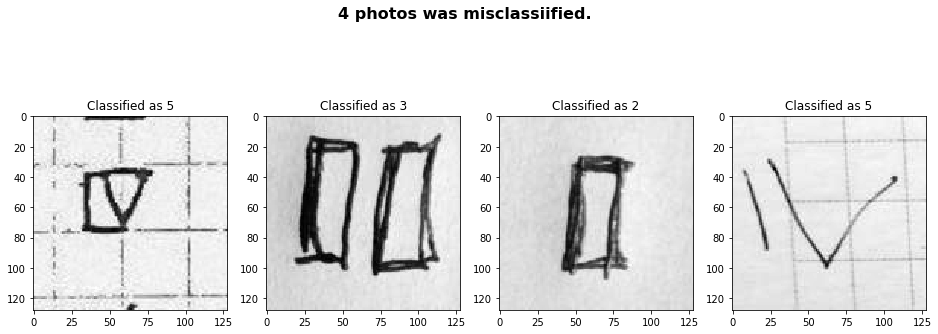

In [39]:
m.plot_misclassified(dat['train'], batch=256)